# Music Application

## Introduction

In this notebook, we will explore different aspects of sound synthesis, talkbox effects, and music generation. This notebook will guide you through the basics of 
- synthesizing sounds
- using a talkbox to modulate speech with a guitar signal
- generating music with drums and piano

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import AudioSigPy as asp

asp.manage_directory("audio/examples/music")

AudioSigPy package initialized
[WARNING] Manage Directory: The directory audio/examples/music already exists and will not be deleted.


## Sound Synthesis

We'll start by exploring sound synthesis, a fundamental technique in audio processing. First, we'll generate a simple frequency modulation (FM) signal as shown on SuperCollider's [example page](https://supercollider.github.io/examples.html). 
```
{ SinOsc.ar(SinOsc.kr([1, 3]).exprange(100, 2e3), 0, 0.2) }.play
```

Then, we'll synthesize a C4 note on a piano by extracting key parameters from a real audio sample. These examples will demonstrate how you can create and manipulate audio signals from scratch.

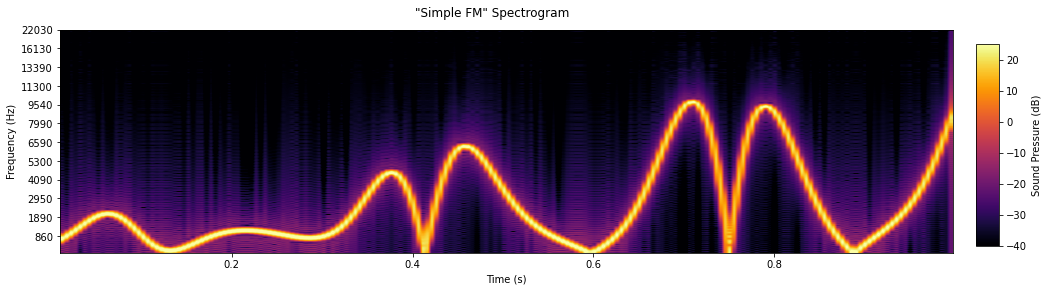

In [2]:
# SuperCollider Simple FM example
duration = 1
sample_rate = 44100

# Step 1: Control waves — SinOsc.kr([1, 3])
freqs = [1, 3]
sine_control = [asp.sine(frequency=f, duration=duration, sample_rate=sample_rate) for f in freqs]

# Step 2: Exponential scaling — exprange(100, 2e3)
x = [100, 2e3]
exp_control = np.mean([x[0] * (x[1] / x[0]) ** ((sc + 1) / 2) for sc in sine_control], axis=0)

# Step 3: Create audio wave
params = {
    "frequency": exp_control, 
    "sample_rate": sample_rate,
    "phase": 0,
    "amplitude": 0.2
}
audio_wave = asp.choose_generator(duration=None, name="sine", args=params)

# Load array data into Waveform object to view
wf = asp.Waveform("Simple FM")
wf.set_signal_data(data=audio_wave, sample_rate=sample_rate)
wf.plot_spectrogram()
wf.write("audio/examples/music/fm.wav")

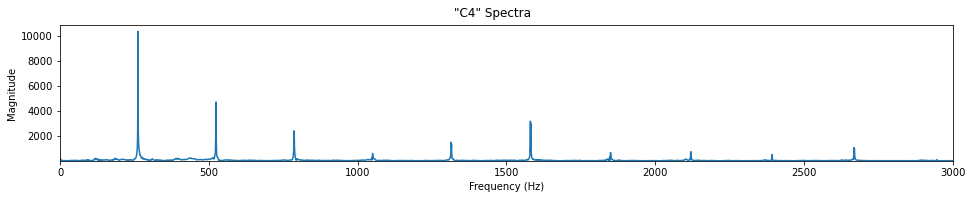

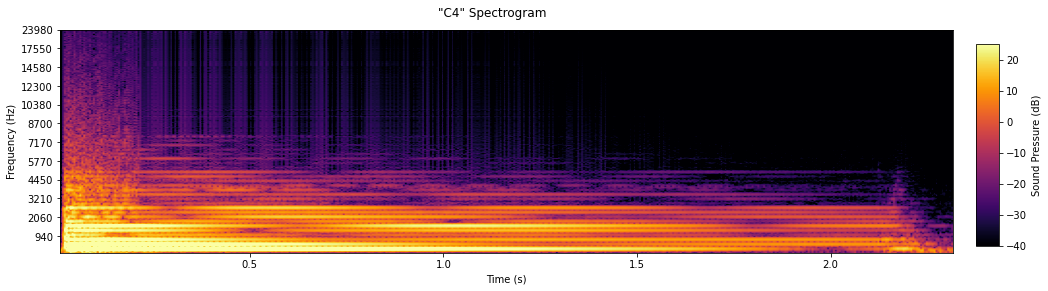

In [3]:
wf = asp.Waveform("C4")
wf.read("audio/samples/piano/c4 samples/c4-f-medium.wav")
wf.plot_spectra(spectrum="magnitude", log_freq=False, xlim=(0, 3000))
wf.plot_spectrogram()

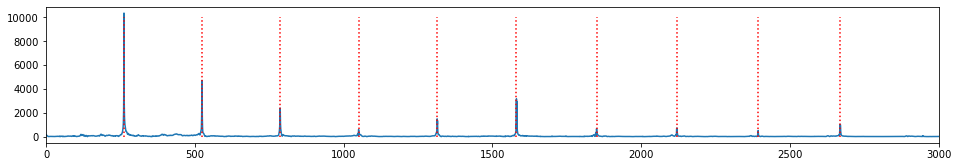

In [4]:
_, mag_sp, _ = asp.calc_spectra(signal=wf.get_signal_data(), clip=True)
freqs = wf.frequency_series(clip=True)

peaks = asp.find_peaks(signal = mag_sp, height = 500)[0]
peaks = peaks[np.array([0, 1, 2, 3, 4, 7, 9, 11, 12, 13])]

plt.figure(figsize=(16, 2.5))
plt.plot(freqs, mag_sp)
plt.vlines(freqs[peaks], 0, 10000, "r", "dotted")
plt.xlim(0, 3000)

plt.show()

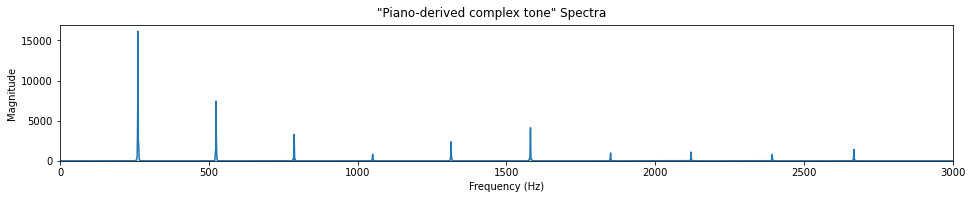

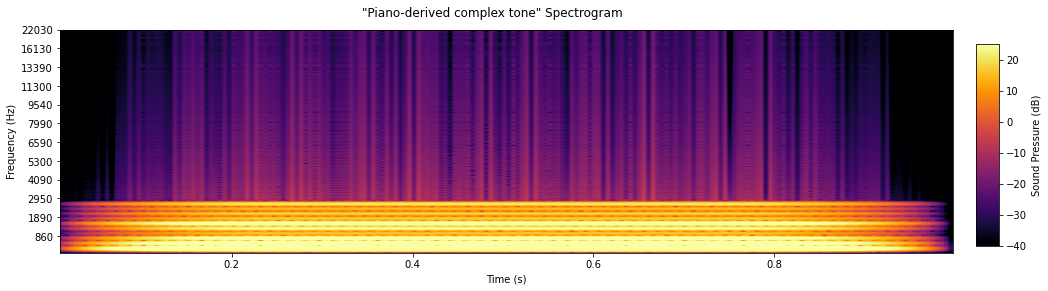

In [5]:
frequencies = np.round(freqs[peaks], 2).flatten()
magnitudes = np.round(mag_sp[peaks], 2).flatten()

magnitudes /= np.max(magnitudes)

signals = []
for i in range(len(frequencies)):
    signal = asp.sine(frequency=frequencies[i], duration=1, amplitude=magnitudes[i])
    signals.append(signal)

complex_signal = np.hstack(signals).sum(axis=1).reshape((-1, 1))
window = asp.choose_window(complex_signal.shape[0], "tukey")
complex_signal *= window

wf = asp.Waveform("Piano-derived complex tone")
wf.set_signal_data(data=complex_signal, duration=1)
wf.plot_spectra(spectrum="magnitude", log_freq=False, xlim=(0, 3000))
wf.plot_spectrogram()

wf.write("audio/examples/music/c4-tone.wav")

## Talkbox Effect

Next, we'll dive into the talkbox effect, a unique audio effect that uses the shape of the mouth to modulate the sound of an instrument, typically a guitar. By using a guitar signal as the carrier and a speech signal as the modulator, we'll create a classic talkbox effect, similar to the sound heard in many iconic songs.

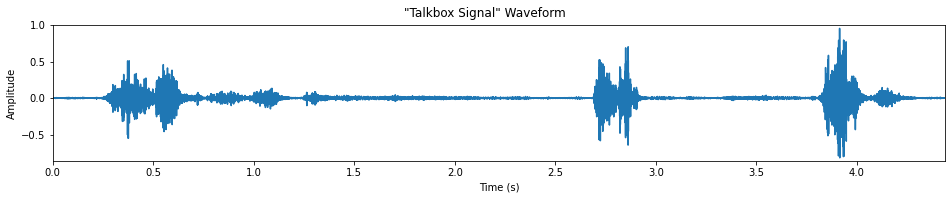

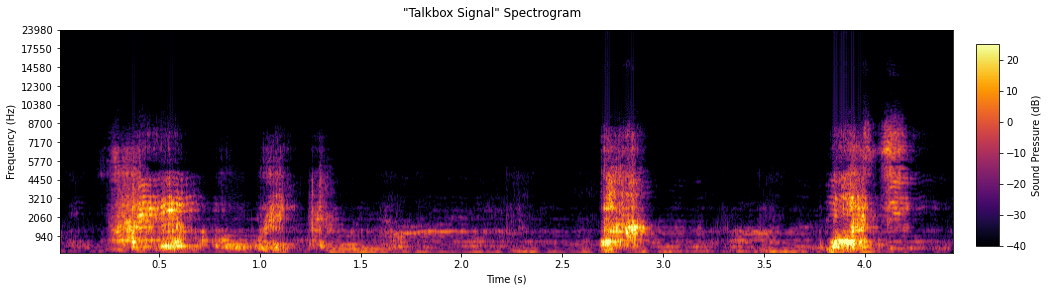

In [12]:
# Load carrier and modulator signals
carrier = asp.Waveform("Carrier Signal")
carrier.read("audio/samples/songs/anti-hero-sample2.wav")
modulator = asp.Waveform("Modulator Signal")
modulator.read("audio/samples/speech/breaking-bad-awake.wav")
assert carrier.get_sample_rate() == modulator.get_sample_rate(), f"{carrier.get_sample_rate()} != {modulator.get_sample_rate()}"
fs = carrier.get_sample_rate()

# Start a talkbox processor instance
talkbox = asp.Talkbox()

# Process the modulator signal 
talkbox_mod = talkbox.process(
    signal=modulator.get_signal_data()[:, 0],
    sample_rate=fs
)

# Apply the modulator on the carrier signal
talkbox_signal = talkbox.signal(
    carrier=carrier.get_signal_data()[:, 0],
    modulator=talkbox_mod,
    sample_rate=fs
)

# Save the talkbox signal as a .wav file
wf_talkbox = asp.Waveform("Talkbox Signal")
wf_talkbox.set_signal_data(data=talkbox_signal, sample_rate=fs)
wf_talkbox.plot_waveform(overlay=True)
wf_talkbox.plot_spectrogram(channel=0)
wf_talkbox.write("audio/examples/music/talkbox.wav")

## Generating Music: Drums and Piano

Finally, we'll generate some music using synthesized drums and piano. This combines sound synthesis and rhythmic pattern creation, which gives rise to music. Here we generate a short tune from "Bella Ciao."

In [8]:
# Amplitude levels for music volumes
pp, p, mp, mf, f, ff = np.linspace(0.1, 0.8, 6)

# Set the base unit for the song, Bella Ciao
bella_ciao = {"base_unit": 1/8}

# Set the note IDs: C-0, C#-1, ..., A#-10, B-11
bella_ciao["notes"] = [
    # Right hand
    11, 4, 6, 11, 4, 6, 7, 4, 11, 4, 6, 11, 4, 6, 7, 4, 11, 4, 6, 11, 4, 6, 7, 6, 4, 11, 2, 4, 7, 6, 4, 4, 7, 11, [4, 7, 11], 3, 6, 11, 9, 11, [9, 0], [9, 0], [0, 4], [11, 2], [9, 0], [11, 4], [7, 11], 7, 9, 7, 9, 7, 6, 11, 7, 6, 4,
    # Left hand
    4, 7, 11, 4, 7, 4, 11, 4, 6, 7, 6, 4, 11, 4, 11, 4, 11, 2, 9, 2, 9, 0, 7, 0, 7, 11, 3, 6, 11, 9, 0, 4, 9, 11, 4, 11, 4, 6, 7, 11, 3, 6, 9, 11, 4, 11, 4
]

# Set the octave IDs: Middle C is in octave 4
bella_ciao["octaves"] = [
    # Right hand
    4, 5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, [5, 5, 5], 5, 5, 5, 5, 5, [5, 6], [5, 6], [6, 6], [5, 6], [5, 6], [5, 6], [5, 5], 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
    # Left hand
    3, 3, 3, 4, 4, 3, 3, 4, 4, 4, 4, 4, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 4, 4, 4, 2, 3, 3, 3, 3, 2, 2, 3,
]

# Set the beat durations of each signal
bella_ciao["durations"] = [
    # Right hand
    1, 1, 1, 0.5, 0.5, 0.5, 7.6, 7, 3, 2, 1, 0.5, 0.5, 0.5, 7.6, 7, 3, 2, 1, 0.5, 0.5, 0.5, 3.6, 2, 1, 0.5, 0.5, 0.5, 3.6, 2, 1, 4, 3.8, 3.6, 2, 4, 3.8, 3.6, 2, 1, 8, 8-4/3, 3, 2, 1, 8, 7, 2.2, 2, 1, 0.7, 0.4, 8, 6, 4, 2, 16,
    # Left hand
    8, 7, 6, 5, 4, 8, 7, 6, 5, 4, 3, 2, 1, 4, 3, 2, 1, 4, 3, 2, 1, 4, 3, 2, 1, 4, 3, 2, 1, 8, 7, 6, 5, 4, 8, 7, 6, 5, 4, 8, 7, 6, 5, 4, 16, 16, 16,
]

# Set the beats of each signal
bella_ciao["beats"] = [
    # Right hand
    5, 6, 7, 7.8, 8, 8.2, 8.4, 9, 13, 14, 15, 15.8, 16, 16.2, 16.4, 17, 21, 22, 23, 23.8, 24, 24.2, 24.4, 26, 27, 27.8, 28, 28.2, 28.4, 30, 31, 32, 32.2, 32.4, 34, 36, 36.2, 36.4, 38, 39, 40, 40+4/3, 45, 46, 47, 48, 49, 53.8, 54, 55, 55.3, 55.6, 56, 58, 60, 62, 64.6,
    # Left hand
    8, 9, 10, 11, 12, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 48, 49, 50, 51, 52, 56, 57, 58, 59, 60, 64, 64.2, 64.4,
]

# Set the amplitudes for each signal
bella_ciao["amplitudes"] = [p] * len(bella_ciao["notes"])

# Set the tempo for each signal
bella_ciao["tempos"] = [120] * len(bella_ciao["notes"])

# 80s beat rhythm to add to piano song
types = ["closed_hihat"] * 14 + ["kick_drum"] * 3 + ["snare_drum"] * 2
beats = [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15] + [0, 6, 7] + [4, 12]
durations = [1] * 14 + [2] * 3 + [2] * 2
amplitudes = [pp] * 14 + [p] * 3 + [mp] * 2
tempos = [120] * 14 + [120] * 3 + [120] * 2

bc_drum = {"base_unit": 1/16}
bc_drum["types"] = types * 8 + ["crash_cymbal"]
bc_drum["beats"] = [b + i*16 for i in range(8) for b in beats] + [128]
bc_drum["durations"] = durations * 8 + [32]
bc_drum["amplitudes"] = amplitudes * 8 + [p]
bc_drum["tempos"] = tempos * 8 + [120]

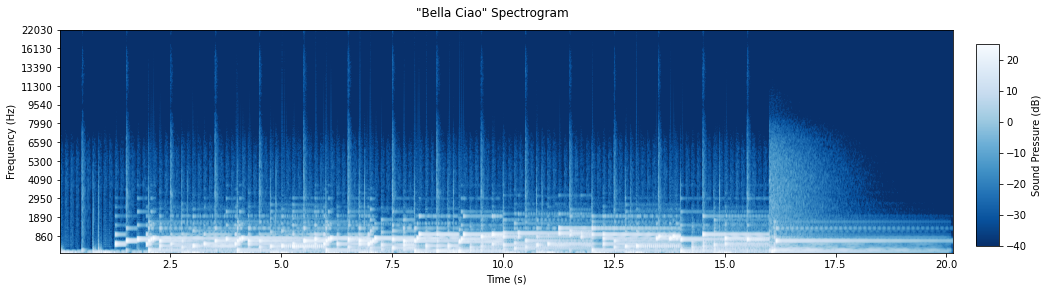

In [9]:
# Set up the synthesizers for piano and drums
piano = asp.Piano()
drumset = asp.Drumset()

# Generate the music signals
piano_track = piano.process(data=bella_ciao)
drum_track = drumset.process(data=bc_drum)

# Adjust track signals for merging
duration = piano_track.get_duration() + drum_track.get_duration() * (5 / 80)
new_signal = np.zeros((int(duration * piano_track.get_sample_rate()), 1))

# Insert tracks into song
new_signal[:drum_track.get_sample_count()] = drum_track.get_signal_data() / 4
new_signal[-piano_track.get_sample_count():] += piano_track.get_signal_data()

# Save song signal as .wav
song = asp.Waveform("Bella Ciao")
song.set_signal_data(data=new_signal, sample_rate=piano_track.get_sample_rate())
song.plot_spectrogram(color_map="Blues_r")
song.write("audio/examples/music/bella-ciao.wav")